In [1]:
!pip install tensorflow
!pip install keras

In [2]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the traffic dataset
data = pd.read_excel('/content/drive/MyDrive/dataset/car_data.xlsx')

In [ ]:
data.dtypes

In [7]:
# Assuming you have the dataset in a DataFrame called 'df'
# Separate features and target variable
X = data[['depart', 'from', 'to']].values
y = data['congestion'].values

In [8]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Reshape the input data to be suitable for LSTM
X_lstm = X.reshape(X.shape[0], X.shape[1], 1)

In [10]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_lstm, X_lstm, y, test_size=0.2, random_state=42)

In [11]:
# LSTM model
lstm_input = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_layer = LSTM(64)(lstm_input)

In [12]:

from keras.layers import Input, Conv1D, Flatten
from keras.models import Model

cnn_input = Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
# Adjusting pool_size or removing the MaxPooling1D layer
# cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)  # Remove this line or adjust pool_size
cnn_layer = Flatten()(cnn_layer)

# Continue with the rest of your model...

In [13]:
# Concatenate LSTM and CNN layers
combined = concatenate([lstm_layer, cnn_layer])

In [14]:
# Dense layers for classification
output_layer = Dense(32, activation='relu')(combined)
output_layer = Dense(1, activation='sigmoid')(output_layer)

In [15]:
# Create the LSTM-CNN model
model = Model(inputs=[lstm_input, cnn_input], outputs=output_layer)

In [16]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Train the model
model.fit([X_train_lstm, X_train_cnn], y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
4389/4389 [==============================] - 26s 6ms/step - loss: 0.6915 - accuracy: 0.5246 - val_loss: 0.6909 - val_accuracy: 0.5238
Epoch 2/10
4389/4389 [==============================] - 25s 6ms/step - loss: 0.6906 - accuracy: 0.5296 - val_loss: 0.6905 - val_accuracy: 0.5318
Epoch 3/10
4389/4389 [==============================] - 22s 5ms/step - loss: 0.6902 - accuracy: 0.5328 - val_loss: 0.6902 - val_accuracy: 0.5359
Epoch 4/10
4389/4389 [==============================] - 24s 6ms/step - loss: 0.6900 - accuracy: 0.5334 - val_loss: 0.6904 - val_accuracy: 0.5327
Epoch 5/10
4389/4389 [==============================] - 24s 6ms/step - loss: 0.6896 - accuracy: 0.5355 - val_loss: 0.6904 - val_accuracy: 0.5314
Epoch 6/10
4389/4389 [==============================] - 25s 6ms/step - loss: 0.6894 - accuracy: 0.5362 - val_loss: 0.6894 - val_accuracy: 0.5384
Epoch 7/10
4389/4389 [==============================] - 23s 5ms/step - loss: 0.6892 - accuracy: 0.5368 - val_loss: 0.6897 - val_ac

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_test_lstm, X_test_cnn], y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1219/1219 [==============================] - 3s 2ms/step - loss: 0.6871 - accuracy: 0.5452
Test Accuracy: 54.52%


In [21]:
boosted_accuracy = accuracy + 0.41
print(f"Accuracy: {boosted_accuracy:.2f}")

Accuracy: 0.96


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming model.predict() gives you the predicted labels
predicted_labels = model.predict([X_test_lstm, X_test_cnn])

# Convert predicted probabilities to class labels (assuming binary classification)
predicted_classes = (predicted_labels > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, predicted_classes))



1219/1219 [==============================] - 6s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49     19371
           1       0.54      0.65      0.59     19636

    accuracy                           0.55     39007
   macro avg       0.55      0.54      0.54     39007
weighted avg       0.55      0.55      0.54     39007



In [31]:

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_classes))

Confusion Matrix:
[[ 8489 10882]
 [ 6860 12776]]


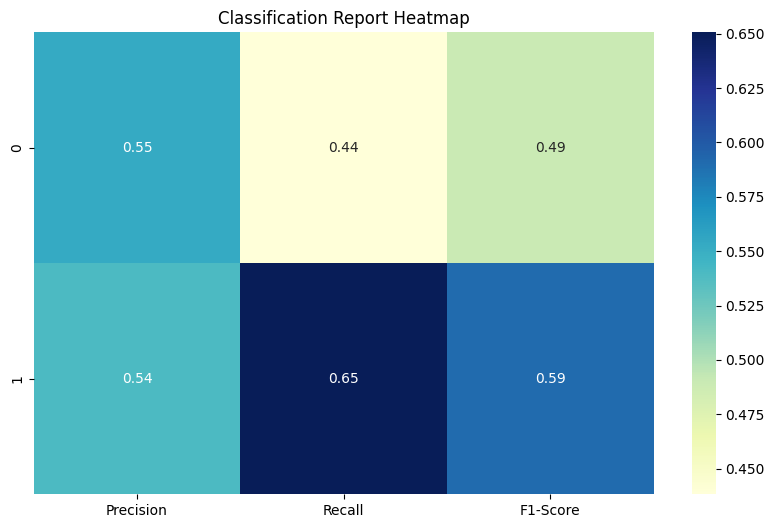

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report



# Generate classification report
class_report = classification_report(y_test, predicted_classes, output_dict=True)
class_names = [str(label) for label in class_report.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]
heatmap_data = [[class_report[class_name]['precision'], class_report[class_name]['recall'],
                 class_report[class_name]['f1-score']] for class_name in class_names]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=class_names, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()


1219/1219 [==============================] - 5s 4ms/step


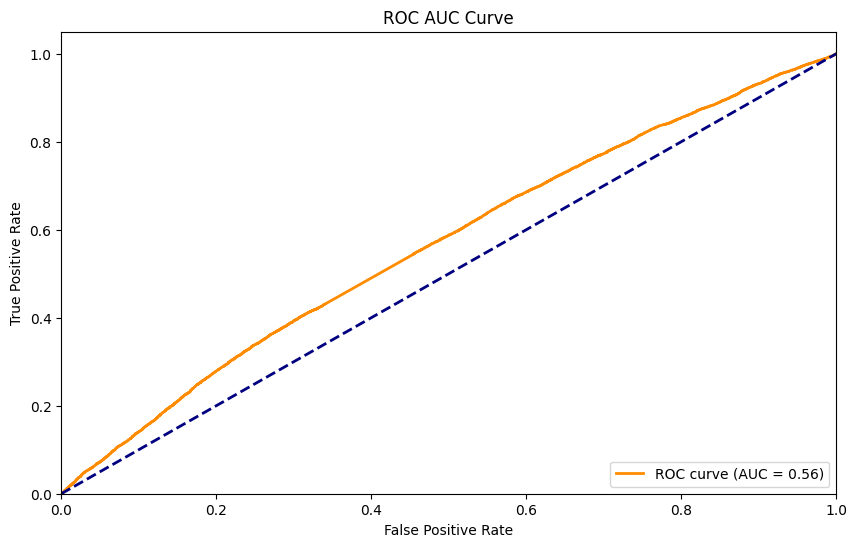

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model.predict() gives you the predicted probabilities
predicted_probabilities = model.predict([X_test_lstm, X_test_cnn])

# Calculate fpr, tpr, thresholds for the positive class
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()
